##BioBert and Word2Vec
With BLEU score


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
# Load your glaucoma Q&A data
df = '/content/Combined_Dataset.xlsx'
data = pd.read_excel(df)

# Inspect the first few rows
print(data.head())

                                 Question  \
0                       What is glaucoma?   
1    What are the main types of glaucoma?   
2      What are the symptoms of glaucoma?   
3  Who is at risk of developing glaucoma?   
4              How is glaucoma diagnosed?   

                                              Answer  
0  Glaucoma is a group of eye conditions that dam...  
1  The two main types of glaucoma are open-angle ...  
2  In early stages, glaucoma often has no symptom...  
3  People over 60, those with a family history of...  
4  Glaucoma is diagnosed through comprehensive ey...  


In [ ]:
# Load BioBERT model and tokenizer
biobert_model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

# Function to compute BioBERT embeddings
def get_biobert_embedding(text):
    inputs = biobert_tokenizer(text, return_tensors='pt', padding=True, truncation=True,max_length=512)
    with torch.no_grad():
        outputs = biobert_model(**inputs)
    # Use the pooled output (the representation of the [CLS] token)
    return outputs.pooler_output.squeeze().numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Biowordvec installation

In [ ]:
!git clone https://github.com/ncbi-nlp/BioWordVec

# Download the BioWordVec model
!wget https://doi.org/10.6084/m9.figshare.6882647

fatal: destination path 'BioWordVec' already exists and is not an empty directory.


In [ ]:
# Load BioWordVec model (ensure you have the correct model file)
word2vec_model = KeyedVectors.load_word2vec_format('/content/bio_embedding_intrinsic', binary=True)

# Function to compute BioWordVec embeddings
def get_biowordvec_embedding(text):
    words = text.split()
    word_vecs = [word2vec_model[word] for word in words if word in word2vec_model]
    if not word_vecs:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vecs, axis=0)


In [ ]:
# Precompute BioBERT and BioWordVec embeddings for all dataset questions
def precompute_embeddings(df):
    # Precompute BioBERT embeddings for all questions
    df['biobert_embedding'] = df['Question'].apply(get_biobert_embedding)

    # Precompute BioWordVec embeddings for all questions
    df['biowordvec_embedding'] = df['Question'].apply(get_biowordvec_embedding)

    # Optionally save the precomputed embeddings to disk
    df.to_pickle('precomputed_embeddings.pkl')
    return df

In [ ]:
# Function to calculate BLEU score
def calculate_bleu_score(reference, hypothesis):
    reference_tokens = reference.split()
    hypothesis_tokens = hypothesis.split()
    return sentence_bleu([reference_tokens], hypothesis_tokens)

In [ ]:
# Function to find the most relevant question and corresponding answer with BLEU scores
def find_best_answer(user_question, df):
    # Get embeddings for the user question
    biobert_user_embedding = get_biobert_embedding(user_question)
    biowordvec_user_embedding = get_biowordvec_embedding(user_question)

    # Calculate similarities with precomputed BioBERT and BioWordVec embeddings
    df['biobert_similarity'] = df['biobert_embedding'].apply(
        lambda x: cosine_similarity([biobert_user_embedding], [x]).flatten()[0]
    )
    df['biowordvec_similarity'] = df['biowordvec_embedding'].apply(
        lambda x: cosine_similarity([biowordvec_user_embedding], [x]).flatten()[0]
    )

    # Find the best match for BioBERT and BioWordVec
    best_biobert_index = df['biobert_similarity'].idxmax()
    best_biowordvec_index = df['biowordvec_similarity'].idxmax()

    best_biobert_answer = df.iloc[best_biobert_index]
    best_biowordvec_answer = df.iloc[best_biowordvec_index]

    # Calculate BLEU score for user question and matched question
    biobert_bleu = calculate_bleu_score(user_question, best_biobert_answer['Question'])
    biowordvec_bleu = calculate_bleu_score(user_question, best_biowordvec_answer['Question'])

    # Calculate BLEU score for BioBERT and BioWordVec answers
    biobert_answer_bleu = calculate_bleu_score(best_biobert_answer['Question'], best_biobert_answer['Answer'])
    biowordvec_answer_bleu = calculate_bleu_score(best_biowordvec_answer['Question'], best_biowordvec_answer['Answer'])

    return {
        'biobert': {
            'question': best_biobert_answer['Question'],
            'answer': best_biobert_answer['Answer'],
            'confidence': df['biobert_similarity'].max(),
            'question_bleu_score': biobert_bleu,
            'answer_bleu_score': biobert_answer_bleu
        },
        'biowordvec': {
            'question': best_biowordvec_answer['Question'],
            'answer': best_biowordvec_answer['Answer'],
            'confidence': df['biowordvec_similarity'].max(),
            'question_bleu_score': biowordvec_bleu,
            'answer_bleu_score': biowordvec_answer_bleu
        }
    }

In [ ]:
# Main chatbot function
def chatbot(df):
    print("Hey there..! I'm Glaucoma Chatbot!")
    print("You can ask any question related to glaucoma or type 'exit' to stop.")

    while True:
        user_question = input("Your question: ")

        if user_question.lower() == 'exit':
            print("Thank-You!")
            break

        result = find_best_answer(user_question, df)

        # Output the matched questions and answers from both models along with BLEU scores
        print("\n--- BioBERT Response ---")
        print(f"Matched Question: {result['biobert']['question']}")
        print(f"Answer: {result['biobert']['answer']}")
        print(f"Confidence: {result['biobert']['confidence']:.2f}")
        print(f"Question BLEU Score: {result['biobert']['question_bleu_score']:.2f}")
        print(f"Answer BLEU Score: {result['biobert']['answer_bleu_score']:.2f}")

        print("\n--- BioWordVec Response ---")
        print(f"Matched Question: {result['biowordvec']['question']}")
        print(f"Answer: {result['biowordvec']['answer']}")
        print(f"Confidence: {result['biowordvec']['confidence']:.2f}")
        print(f"Question BLEU Score: {result['biowordvec']['question_bleu_score']:.2f}")
        print(f"Answer BLEU Score: {result['biowordvec']['answer_bleu_score']:.2f}\n")

# Example usage
if __name__ == "__main__":
    # Precompute embeddings for the dataset
    data = precompute_embeddings(data)

    # Start the chatbot
    chatbot(data)

Hey there..! I'm Glaucoma Chatbot!
You can ask any question related to glaucoma or type 'exit' to stop.
Your question: symptoms of glaucom


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


--- BioBERT Response ---
Matched Question: What medications is the patient currently using for glaucoma management?
Answer: Cosopt BID OU, Brimonidine BID OS, Latanoprost QHS OS, Prednisolone BID OD
Confidence: 0.98
Question BLEU Score: 0.00
Answer BLEU Score: 0.00

--- BioWordVec Response ---
Matched Question: What is the patient's history of glaucoma treatment?
Answer: Latanoprost was added, leading to IOP in the low to middle teens compared to high teens previously.
Confidence: 0.85
Question BLEU Score: 0.00
Answer BLEU Score: 0.00

Your question: treatment of glaucoma


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


--- BioBERT Response ---
Matched Question: Does the patient have any other ocular conditions besides glaucoma?
Answer: Yes, the patient also has mild dry eyes OU.
Confidence: 0.99
Question BLEU Score: 0.00
Answer BLEU Score: 0.00

--- BioWordVec Response ---
Matched Question: What is the patient's glaucoma diagnosis?
Answer: The patient has primary open-angle glaucoma of both eyes (OU), indeterminate stage.
Confidence: 0.94
Question BLEU Score: 0.00
Answer BLEU Score: 0.00

Your question: what recent ocular symptom did the patient report


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


--- BioBERT Response ---
Matched Question: What symptoms did the patient report about vision?
Answer: Vision appears stable, but with reported irritation in the left eye
Confidence: 0.99
Question BLEU Score: 0.35
Answer BLEU Score: 0.00

--- BioWordVec Response ---
Matched Question: What recent ocular symptom did the patient report?
Answer: Itchy eyes.
Confidence: 0.98
Question BLEU Score: 0.68
Answer BLEU Score: 0.00

Your question: what is the symptoms of glaucoma


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


--- BioBERT Response ---
Matched Question: What is the patient's diagnosis related to cataracts?
Answer: The patient has mild cataracts, being monitored by Dr. ******.
Confidence: 1.00
Question BLEU Score: 0.00
Answer BLEU Score: 0.00

--- BioWordVec Response ---
Matched Question: What is the patient's history of glaucoma treatment?
Answer: Latanoprost was added, leading to IOP in the low to middle teens compared to high teens previously.
Confidence: 0.96
Question BLEU Score: 0.00
Answer BLEU Score: 0.00

Your question: exit
Thank-You!


##Main Project
Without BLEU score


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load your glaucoma Q&A data
df = '/content/Combined_Dataset.xlsx'
data = pd.read_excel(df)

# Inspect the first few rows
print(data.head())

# Load BioBERT model and tokenizer
biobert_model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

# Function to compute BioBERT embeddings
def get_biobert_embedding(text):
    inputs = biobert_tokenizer(text, return_tensors='pt', padding=True, truncation=True,max_length=512)
    with torch.no_grad():
        outputs = biobert_model(**inputs)
    # Use the pooled output (the representation of the [CLS] token)
    return outputs.pooler_output.squeeze().numpy()

# Load BioWordVec model (ensure you have the correct model file)
word2vec_model = KeyedVectors.load_word2vec_format('/content/bio_embedding_intrinsic', binary=True)

# Function to compute BioWordVec embeddings
def get_biowordvec_embedding(text):
    words = text.split()
    word_vecs = [word2vec_model[word] for word in words if word in word2vec_model]
    if not word_vecs:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vecs, axis=0)

# Precompute BioBERT and BioWordVec embeddings for all dataset questions
def precompute_embeddings(df):
    # Precompute BioBERT embeddings for all questions
    df['biobert_embedding'] = df['Question'].apply(get_biobert_embedding)

    # Precompute BioWordVec embeddings for all questions
    df['biowordvec_embedding'] = df['Question'].apply(get_biowordvec_embedding)

    # Optionally save the precomputed embeddings to disk
    df.to_pickle('precomputed_embeddings.pkl')
    return df

# Function to find the most relevant question and corresponding answer
def find_best_answer(user_question, df):
    # Get embeddings for the user question
    biobert_user_embedding = get_biobert_embedding(user_question)
    biowordvec_user_embedding = get_biowordvec_embedding(user_question)

    # Calculate similarities with precomputed BioBERT and BioWordVec embeddings
    df['biobert_similarity'] = df['biobert_embedding'].apply(
        lambda x: cosine_similarity([biobert_user_embedding], [x]).flatten()[0]
    )
    df['biowordvec_similarity'] = df['biowordvec_embedding'].apply(
        lambda x: cosine_similarity([biowordvec_user_embedding], [x]).flatten()[0]
    )

    # Find the best match for BioBERT and BioWordVec
    best_biobert_index = df['biobert_similarity'].idxmax()
    best_biowordvec_index = df['biowordvec_similarity'].idxmax()

    best_biobert_answer = df.iloc[best_biobert_index]
    best_biowordvec_answer = df.iloc[best_biowordvec_index]

    return {
        'biobert': {
            'question': best_biobert_answer['Question'],
            'answer': best_biobert_answer['Answer'],
            'confidence': df['biobert_similarity'].max()
        },
        'biowordvec': {
            'question': best_biowordvec_answer['Question'],
            'answer': best_biowordvec_answer['Answer'],
            'confidence': df['biowordvec_similarity'].max()
        }
    }

# Main chatbot function
def chatbot(df):
    print("Hey there..! I'm Glaucoma Chatbot!")
    print("You can ask any question related to glaucoma or type 'exit' to stop.")

    while True:
        user_question = input("Your question: ")

        if user_question.lower() == 'exit':
            print("Thank-You!")
            break

        result = find_best_answer(user_question, df)

        # Output the matched questions and answers from both models
        print("\n--- BioBERT Response ---")
        print(f"Matched Question: {result['biobert']['question']}")
        print(f"Answer: {result['biobert']['answer']}")
        print(f"Confidence: {result['biobert']['confidence']:.2f}")

        print("\n--- BioWordVec Response ---")
        print(f"Matched Question: {result['biowordvec']['question']}")
        print(f"Answer: {result['biowordvec']['answer']}")
        print(f"Confidence: {result['biowordvec']['confidence']:.2f}\n")

# Example usage
if __name__ == "__main__":
    # Precompute embeddings for the dataset
    data = precompute_embeddings(data)

    # Start the chatbot
    chatbot(data)

                                 Question  \
0                       What is glaucoma?   
1    What are the main types of glaucoma?   
2      What are the symptoms of glaucoma?   
3  Who is at risk of developing glaucoma?   
4              How is glaucoma diagnosed?   

                                              Answer  
0  Glaucoma is a group of eye conditions that dam...  
1  The two main types of glaucoma are open-angle ...  
2  In early stages, glaucoma often has no symptom...  
3  People over 60, those with a family history of...  
4  Glaucoma is diagnosed through comprehensive ey...  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Hey there..! I'm Glaucoma Chatbot!
You can ask any question related to glaucoma or type 'exit' to stop.
Your question: what is the symptoms of glaucpma

--- BioBERT Response ---
Matched Question: What is the patient's diagnosis related to dry eye?
Answer: The patient is diagnosed with dry eye in both eyes (OU).
Confidence: 1.00

--- BioWordVec Response ---
Matched Question: What are the symptoms of glaucoma?
Answer: In early stages, glaucoma often has no symptoms. As the disease progresses, symptoms may include loss of peripheral vision, eye pain, blurred vision, or halos.
Confidence: 0.97

Your question: exit
Thank-You!


##Future work
To use LDA


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Load your glaucoma Q&A data
df_path = '/content/Our_Dataset.xlsx'  # This line is unchanged
df = pd.read_excel(df_path)  # df now holds the DataFrame

# Inspect the first few rows
print(df.head()) # Changed df_path to df

# Split data into 80-20 train-test ratio
train, test = train_test_split(df, test_size=0.2, random_state=42)

                                            Question  \
0  "I’ve been seeing halos around lights, especia...   
1  "My vision is getting worse, especially my sid...   
2  "I don’t feel pain, but my vision seems to be ...   
3  "Why do I need regular check-ups if I don’t fe...   
4     "Is there a way to cure glaucoma permanently?"   

                                              Answer  
0  May be glaucoma or cataracts.Eye drops or surg...  
1  Likely glaucoma.\tEye drops, laser, or surgery...  
2  Could be glaucoma. Regular monitoring and pres...  
3  Glaucoma often has no early symptoms.Preventat...  
4  Glaucoma has no cure, but it can be managed.Ey...  


In [ ]:
# Load BioBERT model and tokenizer
biobert_model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

# Function to compute BioBERT embeddings
def get_biobert_embedding(text):
    inputs = biobert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = biobert_model(**inputs)
    # Use the pooled output (the representation of the [CLS] token)
    return outputs.pooler_output.squeeze().numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Load BioWordVec model (ensure you have the correct model file)
word2vec_model = KeyedVectors.load_word2vec_format('/content/bio_embedding_intrinsic', binary=True)

# Function to compute BioWordVec embeddings
def get_biowordvec_embedding(text):
    words = text.split()
    word_vecs = [word2vec_model[word] for word in words if word in word2vec_model]
    if not word_vecs:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vecs, axis=0)

In [ ]:
# Precompute BioBERT and BioWordVec embeddings for all dataset questions
def precompute_embeddings(df):
    # Precompute BioBERT embeddings for all questions
    df['biobert_embedding'] = df['Question'].apply(get_biobert_embedding)

    # Precompute BioWordVec embeddings for all questions
    df['biowordvec_embedding'] = df['Question'].apply(get_biowordvec_embedding)

    # Optionally save the precomputed embeddings to disk
    df.to_pickle('precomputed_embeddings.pkl')
    return df

In [ ]:
# Function to perform LDA topic modeling and generate word cloud
def lda_topic_modeling(df):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['Question'])

    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X)

    # Display the word cloud of topics
    terms = vectorizer.get_feature_names_out()
    topic_words = []
    for topic_idx, topic in enumerate(lda.components_):
        terms_in_topic = [terms[i] for i in topic.argsort()[:-11:-1]]
        topic_words.extend(terms_in_topic)

    wordcloud = WordCloud(width=800, height=400).generate(" ".join(topic_words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

 # Return the LDA model for topic prediction
    return lda, vectorizer

In [ ]:
# Function to find the most relevant question and corresponding answer
def find_best_answer(user_question, df):
    # Get embeddings for the user question
    biobert_user_embedding = get_biobert_embedding(user_question)
    biowordvec_user_embedding = get_biowordvec_embedding(user_question)

    # Calculate similarities with precomputed BioBERT and BioWordVec embeddings
    df['biobert_similarity'] = df['biobert_embedding'].apply(
        lambda x: cosine_similarity([biobert_user_embedding], [x]).flatten()[0]
    )
    df['biowordvec_similarity'] = df['biowordvec_embedding'].apply(
        lambda x: cosine_similarity([biowordvec_user_embedding], [x]).flatten()[0]
    )

    # Find the best match for BioBERT and BioWordVec
    # Use .reset_index() before calling idxmax to get correct index
    best_biobert_index = df['biobert_similarity'].reset_index(drop=True).idxmax()
    best_biowordvec_index = df['biowordvec_similarity'].reset_index(drop=True).idxmax()

    best_biobert_answer = df.iloc[best_biobert_index]
    best_biowordvec_answer = df.iloc[best_biowordvec_index]

    return {
        'biobert': {
            'question': best_biobert_answer['Question'],
            'answer': best_biobert_answer['Answer'],
            'confidence': df['biobert_similarity'].max()
        },
        'biowordvec': {
            'question': best_biowordvec_answer['Question'],
            'answer': best_biowordvec_answer['Answer'],
            'confidence': df['biowordvec_similarity'].max()
        }
    }

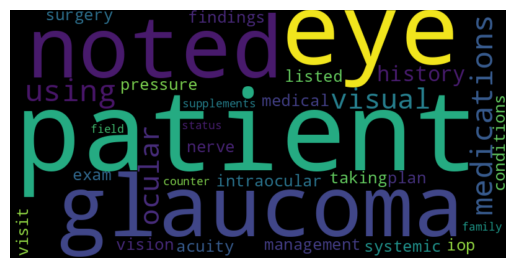

Accuracy: 25.00%
Hey there..! I'm Glaucoma Chatbot!
You can ask any question related to glaucoma or type 'exit' to stop.
Your question: I cannot see light

--- BioBERT Response ---
Matched Question: "Will I eventually lose all my vision because of glaucoma?"
Answer: "With proper treatment and regular monitoring, many people with glaucoma can maintain useful vision for life. However, untreated glaucoma can lead to total blindness over time."
Confidence: 0.99

--- BioWordVec Response ---
Matched Question: "Why do bright lights bother me so much? Could this be glaucoma?"
Answer: "No, this sounds more like cataracts, which cause increased sensitivity to light. Glaucoma primarily affects peripheral vision and doesn’t typically cause light sensitivity."
Confidence: 0.86

Your question: I am having red and watery eyes and have irritation

--- BioBERT Response ---
Matched Question: "Why do I need regular visual field tests?"
Answer: "Visual field tests help us detect any loss in peripheral vis

In [ ]:
# Main chatbot function
def chatbot(df):
    print("Hey there..! I'm Glaucoma Chatbot!")
    print("You can ask any question related to glaucoma or type 'exit' to stop.")

    while True:
        user_question = input("Your question: ")

        if user_question.lower() == 'exit':
            print("Thank-You!")
            break

        result = find_best_answer(user_question, df)

        # Output the matched questions and answers from both models
        print("\n--- BioBERT Response ---")
        print(f"Matched Question: {result['biobert']['question']}")
        print(f"Answer: {result['biobert']['answer']}")
        print(f"Confidence: {result['biobert']['confidence']:.2f}")

        print("\n--- BioWordVec Response ---")
        print(f"Matched Question: {result['biowordvec']['question']}")
        print(f"Answer: {result['biowordvec']['answer']}")
        print(f"Confidence: {result['biowordvec']['confidence']:.2f}\n")

# Calculate accuracy based on matching questions in the test set
def calculate_accuracy(df, test):
    correct = 0
    total = len(test)

    for _, row in test.iterrows():
        user_question = row['Question']
        matched_answer = find_best_answer(user_question, df)

        # Check if the matched answer is the same as the ground truth answer in the test set
        if matched_answer['biobert']['answer'] == row['Answer'] or matched_answer['biowordvec']['answer'] == row['Answer']:
            correct += 1

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Example usage
if __name__ == "__main__":
    # Precompute embeddings for the dataset
    data = precompute_embeddings(data)

    # Perform LDA and display the word cloud
    lda_topic_modeling(data)

    # Calculate accuracy
    calculate_accuracy(data, test)

    # Start the chatbot
    chatbot(data)